
# Forced Alignment with Wav2Vec2

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to align transcript to speech with
``torchaudio``, using CTC segmentation algorithm described in
[CTC-Segmentation of Large Corpora for German End-to-end Speech
Recognition](https://arxiv.org/abs/2007.09127)_.


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1.13.1+cu117
0.13.1+cu117
cuda


## Overview

The process of alignment looks like the following.

1. Estimate the frame-wise label probability from audio waveform
2. Generate the trellis matrix which represents the probability of
   labels aligned at time step.
3. Find the most likely path from the trellis matrix.

In this example, we use ``torchaudio``\ ’s ``Wav2Vec2`` model for
acoustic feature extraction.




## Preparation

First we import the necessary packages, and fetch data that we work on.




In [2]:
# %matplotlib inline

from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)

SPEECH_FILE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

## Generate frame-wise label probability

The first step is to generate the label class porbability of each aduio
frame. We can use a Wav2Vec2 model that is trained for ASR. Here we use
:py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`.

``torchaudio`` provides easy access to pretrained models with associated
labels.

<div class="alert alert-info"><h4>Note</h4><p>In the subsequent sections, we will compute the probability in
   log-domain to avoid numerical instability. For this purpose, we
   normalize the ``emission`` with :py:func:`torch.log_softmax`.</p></div>




In [57]:
SPEECH_FILE = '/home/paperspace/repos/transformers/examples/research_projects/wav2vec2/wavs/g2.wav'

# bundle = torchaudio.pipelines.WAV2VEC2_ASR_LARGE_LV60K_960H #WAV2VEC2_ASR_BASE_960H
# model = bundle.get_model().to(device)

def load_model(model_name):
    bundle = getattr(torchaudio.pipelines, model_name)
    model = bundle.get_model()
    return model, bundle

MODEL_SR = 16_000

model_name = 'WAV2VEC2_ASR_LARGE_LV60K_960H'
model, bundle = load_model(model_name)
model.eval()
model.to(device)

def load_audio(wav_file):
    wav, sr = torchaudio.load(wav_file)
    if sr != MODEL_SR:
        print(f'Resampling from {sr} to {MODEL_SR}')
        wav = torchaudio.transforms.Resample(sr, MODEL_SR)(wav)
    return wav

audio = load_audio(SPEECH_FILE)
audio = audio.to(device)

def get_emissions(model, audio):
    emissions, _ = model(audio)
    emissions = torch.log_softmax(emissions, dim=-1)
    return emissions

emissions = get_emissions(model, audio)
emissions = emissions[0].detach().cpu()


In [27]:
# labels = bundle.get_labels()
# with torch.inference_mode():
#     waveform, _ = torchaudio.load(SPEECH_FILE)
#     emissions, _ = model(waveform.to(device))
#     emissions = torch.log_softmax(emissions, dim=-1)

# emission = emissions[0].cpu().detach()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_large_lv60k_asr_ls960.pth" to /home/paperspace/.cache/torch/hub/checkpoints/wav2vec2_fairseq_large_lv60k_asr_ls960.pth


  0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [28]:
# torchaudio.pipelines.WAV2VEC2_ASR_LARGE_LV60K_960H

### Visualization



('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


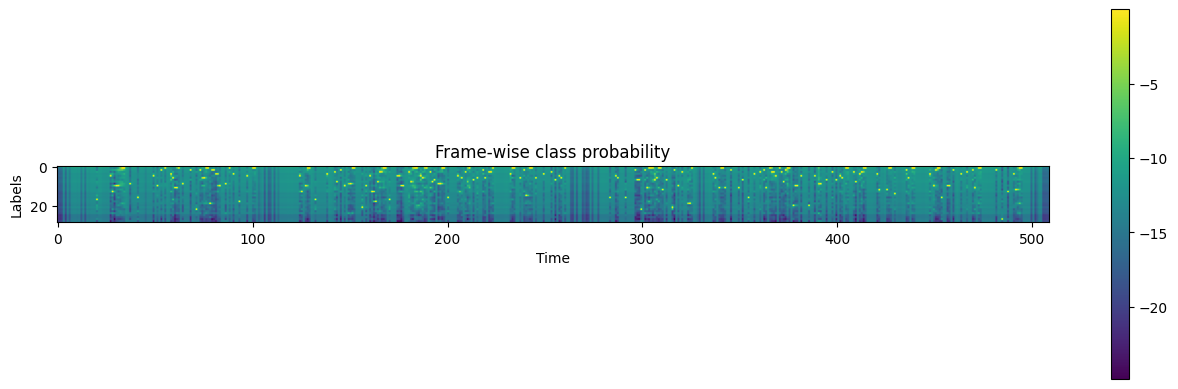

In [58]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

## Generate alignment probability (trellis)

From the emission matrix, next we generate the trellis which represents
the probability of transcript labels occur at each time frame.

Trellis is 2D matrix with time axis and label axis. The label axis
represents the transcript that we are aligning. In the following, we use
$t$ to denote the index in time axis and $j$ to denote the
index in label axis. $c_j$ represents the label at label index
$j$.

To generate, the probability of time step $t+1$, we look at the
trellis from time step $t$ and emission at time step $t+1$.
There are two path to reach to time step $t+1$ with label
$c_{j+1}$. The first one is the case where the label was
$c_{j+1}$ at $t$ and there was no label change from
$t$ to $t+1$. The other case is where the label was
$c_j$ at $t$ and it transitioned to the next label
$c_{j+1}$ at $t+1$.

The follwoing diagram illustrates this transition.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png">

Since we are looking for the most likely transitions, we take the more
likely path for the value of $k_{(t+1, j+1)}$, that is

$k_{(t+1, j+1)} = max( k_{(t, j)} p(t+1, c_{j+1}), k_{(t, j+1)} p(t+1, repeat) )$

where $k$ represents is trellis matrix, and $p(t, c_j)$
represents the probability of label $c_j$ at time step $t$.
$repeat$ represents the blank token from CTC formulation. (For the
detail of CTC algorithm, please refer to the *Sequence Modeling with CTC*
[[distill.pub](https://distill.pub/2017/ctc/)_])




In [59]:
# transcript = "I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT"
ts = 'four score and seven years ago our fathers brought forth on this continent a new nation conceived in Liberty and dedicated to the proposition that all men are created equal'
ts = '|'.join(ts.split(' ')).upper()
transcript = ts

In [60]:
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

[('F', 17), ('O', 5), ('U', 13), ('R', 10), ('|', 1), ('S', 9), ('C', 16), ('O', 5), ('R', 10), ('E', 2), ('|', 1), ('A', 4), ('N', 6), ('D', 11), ('|', 1), ('S', 9), ('E', 2), ('V', 22), ('E', 2), ('N', 6), ('|', 1), ('Y', 19), ('E', 2), ('A', 4), ('R', 10), ('S', 9), ('|', 1), ('A', 4), ('G', 18), ('O', 5), ('|', 1), ('O', 5), ('U', 13), ('R', 10), ('|', 1), ('F', 17), ('A', 4), ('T', 3), ('H', 8), ('E', 2), ('R', 10), ('S', 9), ('|', 1), ('B', 21), ('R', 10), ('O', 5), ('U', 13), ('G', 18), ('H', 8), ('T', 3), ('|', 1), ('F', 17), ('O', 5), ('R', 10), ('T', 3), ('H', 8), ('|', 1), ('O', 5), ('N', 6), ('|', 1), ('T', 3), ('H', 8), ('I', 7), ('S', 9), ('|', 1), ('C', 16), ('O', 5), ('N', 6), ('T', 3), ('I', 7), ('N', 6), ('E', 2), ('N', 6), ('T', 3), ('|', 1), ('A', 4), ('|', 1), ('N', 6), ('E', 2), ('W', 15), ('|', 1), ('N', 6), ('A', 4), ('T', 3), ('I', 7), ('O', 5), ('N', 6), ('|', 1), ('C', 16), ('O', 5), ('N', 6), ('C', 16), ('E', 2), ('I', 7), ('V', 22), ('E', 2), ('D', 11), ('|

In [61]:
def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.empty((num_frame + 1, num_tokens + 1))
    trellis[0, 0] = 0
    trellis[1:, 0] = torch.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")

    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens)

### Visualization



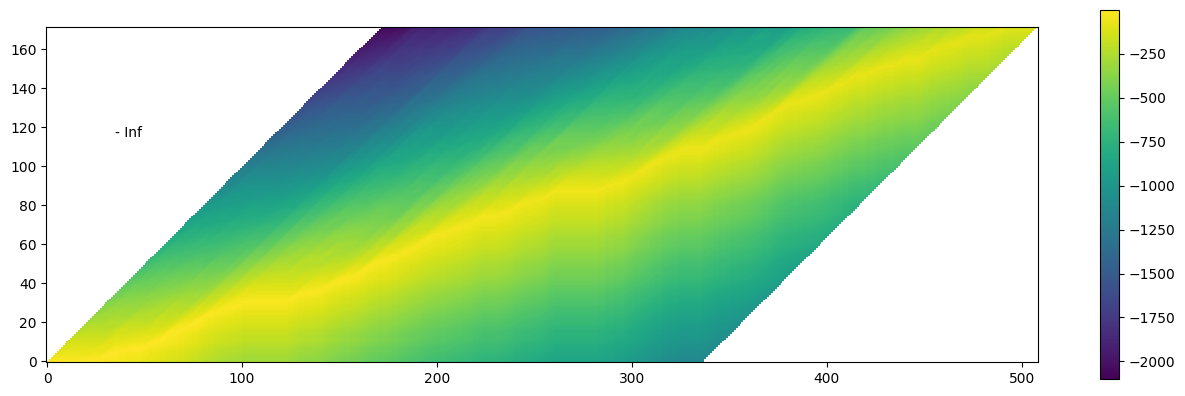

In [62]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In the above visualization, we can see that there is a trace of high
probability crossing the matrix diagonally.




## Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
($c_j \rightarrow c_j$) or transition
($c_j \rightarrow c_{j+1}$), based on the post-transition
probability $k_{t, j} p(t+1, c_{j+1})$ or
$k_{t, j+1} p(t+1, repeat)$.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.




In [63]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=20, score=0.999729335308075)
Point(token_index=0, time_index=21, score=0.9998425245285034)
Point(token_index=0, time_index=22, score=0.9998425245285034)
Point(token_index=0, time_index=23, score=0.9998968839645386)
Point(token_index=0, time_index=24, score=0.9999039173126221)
Point(token_index=0, time_index=25, score=0.9999120235443115)
Point(token_index=0, time_index=26, score=0.9998944997787476)
Point(token_index=1, time_index=27, score=0.9998621940612793)
Point(token_index=2, time_index=28, score=0.9940004348754883)
Point(token_index=2, time_index=29, score=0.9930425882339478)
Point(token_index=3, time_index=30, score=0.9997875094413757)
Point(token_index=3, time_index=31, score=0.33480027318000793)
Point(token_index=3, time_index=32, score=0.9929527640342712)
Point(token_index=3, time_index=33, score=0.18757317960262299)
Point(token_index=4, time_index=34, score=0.8319892287254333)
Point(token_index=4, time_index=35, score=0.9997966885566711)
Point(t

### Visualization



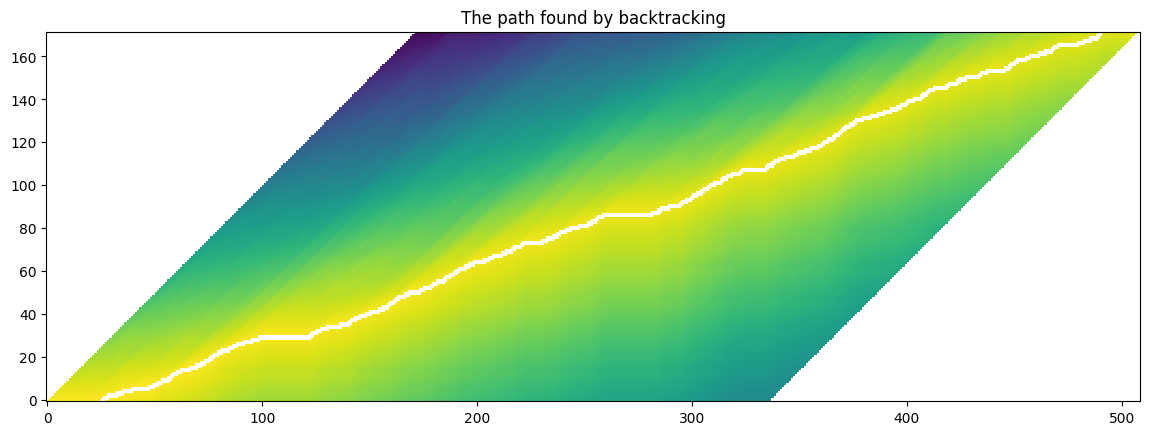

In [64]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

Looking good. Now this path contains repetations for the same labels, so
let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average
probability for the merged segments.




In [65]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

F	(1.00): [   20,    27)
O	(1.00): [   27,    28)
U	(0.99): [   28,    30)
R	(0.63): [   30,    34)
|	(0.94): [   34,    37)
S	(1.00): [   37,    41)
C	(1.00): [   41,    49)
O	(1.00): [   49,    51)
R	(1.00): [   51,    53)
E	(1.00): [   53,    55)
|	(1.00): [   55,    58)
A	(1.00): [   58,    59)
N	(1.00): [   59,    60)
D	(0.52): [   60,    62)
|	(1.00): [   62,    64)
S	(1.00): [   64,    68)
E	(1.00): [   68,    71)
V	(1.00): [   71,    73)
E	(0.93): [   73,    75)
N	(0.86): [   75,    77)
|	(1.00): [   77,    78)
Y	(1.00): [   78,    79)
E	(0.50): [   79,    81)
A	(0.83): [   81,    83)
R	(1.00): [   83,    86)
S	(1.00): [   86,    88)
|	(1.00): [   88,    90)
A	(1.00): [   90,    93)
G	(1.00): [   93,    97)
O	(1.00): [   97,   100)
|	(0.96): [  100,   124)
O	(1.00): [  124,   125)
U	(1.00): [  125,   127)
R	(0.88): [  127,   129)
|	(1.00): [  129,   132)
F	(1.00): [  132,   138)
A	(1.00): [  138,   142)
T	(1.00): [  142,   143)
H	(1.00): [  143,   145)
E	(1.00): [  145,   147)


### Visualization



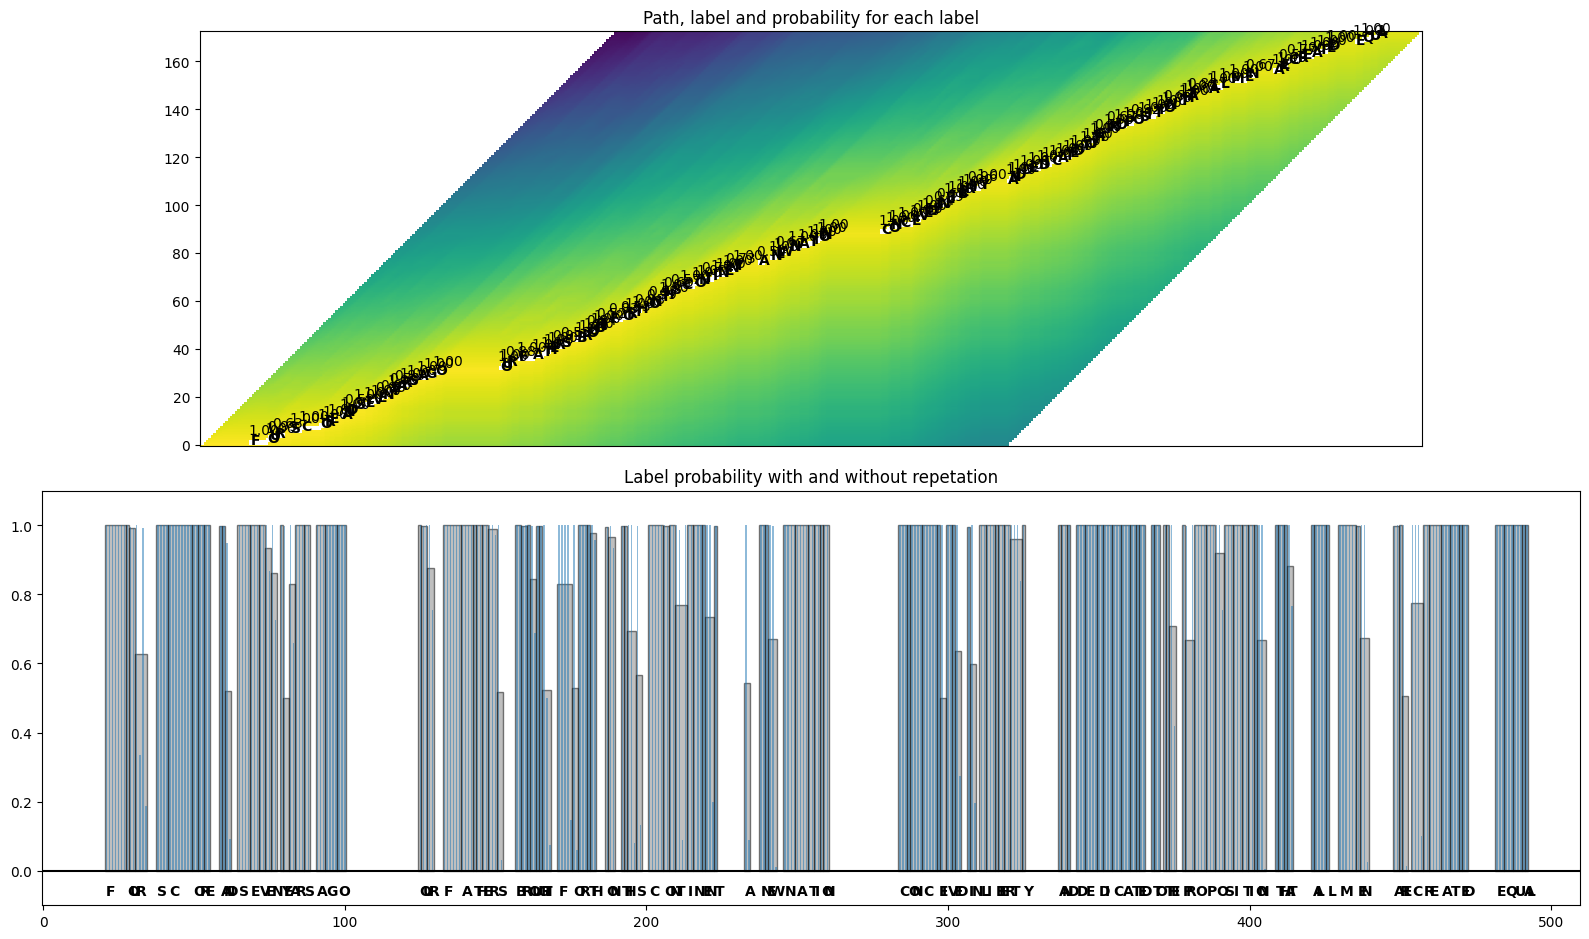

In [66]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

Looks good. Now let’s merge the words. The Wav2Vec2 model uses ``'|'``
as the word boundary, so we merge the segments before each occurance of
``'|'``.

Then, finally, we segment the original audio into segmented audio and
listen to them to see if the segmentation is correct.




In [67]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

FOUR	(0.89): [   20,    34)
SCORE	(1.00): [   37,    55)
AND	(0.76): [   58,    62)
SEVEN	(0.97): [   64,    77)
YEARS	(0.87): [   78,    88)
AGO	(1.00): [   90,   100)
OUR	(0.95): [  124,   129)
FATHERS	(0.95): [  132,   152)
BROUGHT	(0.85): [  156,   168)
FORTH	(0.86): [  170,   183)
ON	(0.98): [  186,   189)
THIS	(0.74): [  191,   198)
CONTINENT	(0.92): [  200,   223)
A	(0.54): [  232,   234)
NEW	(0.83): [  237,   243)
NATION	(1.00): [  245,   260)
CONCEIVED	(0.92): [  283,   304)
IN	(0.73): [  306,   309)
LIBERTY	(0.99): [  310,   325)
AND	(1.00): [  336,   340)
DEDICATED	(1.00): [  342,   365)
TO	(1.00): [  367,   370)
THE	(0.85): [  371,   375)
PROPOSITION	(0.92): [  377,   405)
THAT	(0.96): [  408,   414)
ALL	(1.00): [  420,   426)
MEN	(0.90): [  429,   439)
ARE	(0.80): [  447,   452)
CREATED	(0.95): [  453,   472)
EQUAL	(1.00): [  481,   492)


### Visualization



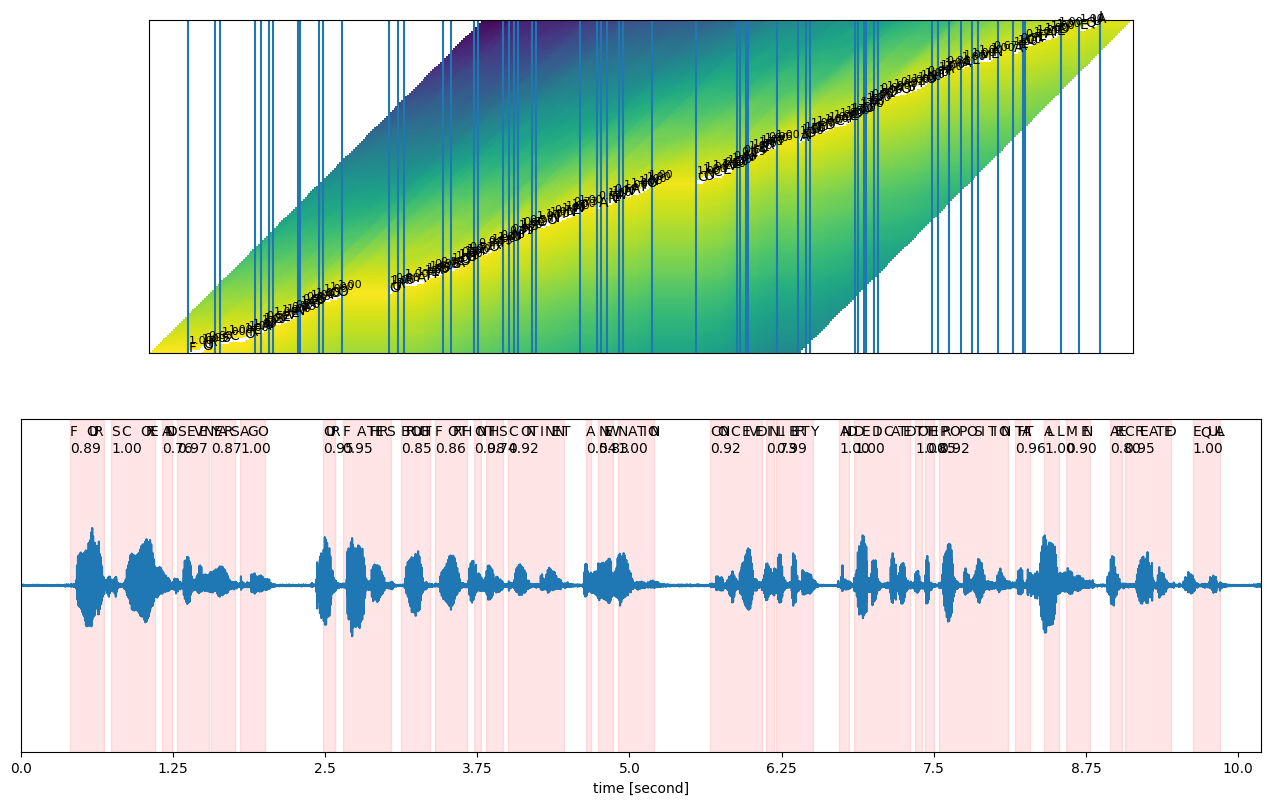

In [68]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / bundle.sample_rate)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()

In [69]:
# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=bundle.sample_rate)

In [70]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

FOUR|SCORE|AND|SEVEN|YEARS|AGO|OUR|FATHERS|BROUGHT|FORTH|ON|THIS|CONTINENT|A|NEW|NATION|CONCEIVED|IN|LIBERTY|AND|DEDICATED|TO|THE|PROPOSITION|THAT|ALL|MEN|ARE|CREATED|EQUAL


In [71]:
display_segment(0)

FOUR (0.89): 0.400 - 0.680 sec


In [72]:
display_segment(1)

SCORE (1.00): 0.741 - 1.101 sec


In [73]:
display_segment(2)

AND (0.76): 1.161 - 1.241 sec


In [74]:
display_segment(3)

SEVEN (0.97): 1.281 - 1.541 sec


In [75]:
display_segment(4)

YEARS (0.87): 1.561 - 1.761 sec


In [76]:
display_segment(5)

AGO (1.00): 1.801 - 2.002 sec


In [77]:
display_segment(6)

OUR (0.95): 2.482 - 2.582 sec


In [78]:
display_segment(7)

FATHERS (0.95): 2.642 - 3.042 sec


In [79]:
display_segment(8)

BROUGHT (0.85): 3.122 - 3.363 sec


In [80]:
display_segment(-1)

EQUAL (1.00): 9.628 - 9.848 sec


## Conclusion

In this tutorial, we looked how to use torchaudio’s Wav2Vec2 model to
perform CTC segmentation for forced alignment.


